<a href="https://colab.research.google.com/github/Ibrahim-Ayaz/ViT-16-Paper-Replication/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 08. Milestone Project 2 PyTorch Paper Replcating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Trabsformer (ViT) architecture/paper with PyTorch.

### 0. Get setup

Let's import code we've previosuly written + required libraries.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 31.97 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Get data

The whole goal of we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak, sushi data images we've been using so far.

In [ ]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip', destination='pizza_steak_sushi')
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Create datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create an image size
img_size = 224 # Comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize(size = (224, 224)), transforms.ToTensor()])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096, but this may be too big for our smaller hardware... Can always scale up later)
batch_size = 32

# Creare DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir, test_dir = test_dir, transform = manual_transforms, batch_size = batch_size)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e521a7e55d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
len(train_dataloader), len(test_dataloader)

(8, 3)

### 2.3 Visualise a single image

As always, let's adhere to the motto: *visualise, visualise, visualise!*

In [ ]:
# Getting a batch of images
img_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = img_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

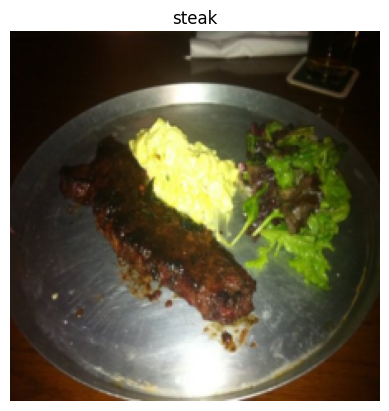

In [ ]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # [colour_channels, height, width] -> [height, width, colour_channels]
plt.title(class_names[label])
plt.axis(False);

### 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So, in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model (In our case, image tensors).
* **Outputs** - What comes out of the model/layer/block (In our case, we want the model to output image classification labels).
* **Layers** - Takes an input, manipulates it with a function (for example, could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of erch layer/ block
* Table 1/3: different hyperparameters for the architecture/training
* Text

##### Figure 1

* Embedding = learnable representation (start with random numbers and improve them over time)

##### Four equations

* Section 3.1 describes the various equations
* MLP = multilayer perceptron = a neural network with x number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

##### Table 1

### 4. Equation 1: Split data into patches and creating the class, position and embedding

Layers = input -> Function -> Output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> Single image -> (Height, width, colour channels)
* Output shape: N * (P**2 * C)

In [ ]:
# Create example values
height = 224
width = 224
colour_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int(height * width / patch_size ** 2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, colour_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * colour_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape}') # -> (number_of_patches, embedding_dimension)

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single into patches

Let's *visualise, visualise, visualise!*

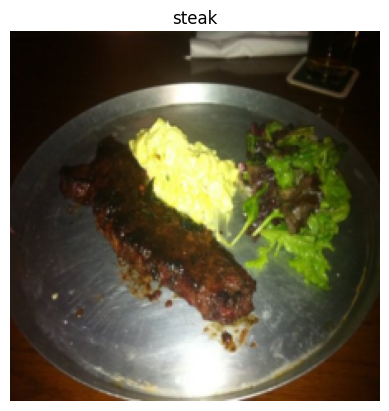

In [ ]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

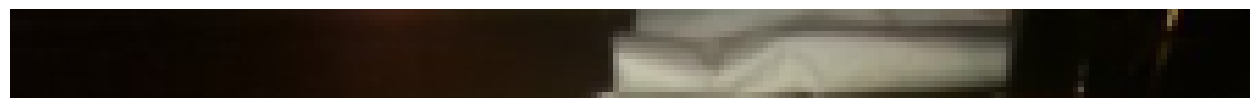

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert image to colour channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Number of patches per row: 14.0
Patch size: 16 pixels * 16 pixels


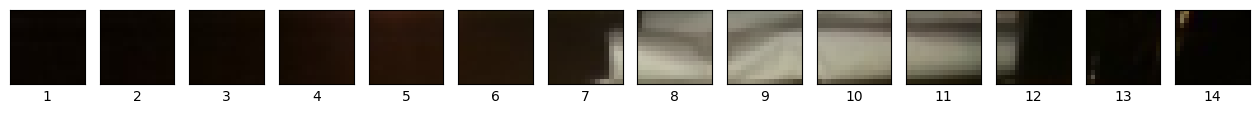

In [ ]:
# Setup code to plot top row as patches
image_size = 224
patch_size = 16
num_patches = image_size / patch_size
assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels * {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1, ncols = image_size // patch_size, sharex = True, sharey = True, figsize = (patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
  axs[i].set_xlabel(i + 1) # Set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
 Patch size: 16 pixels x 16 pixels


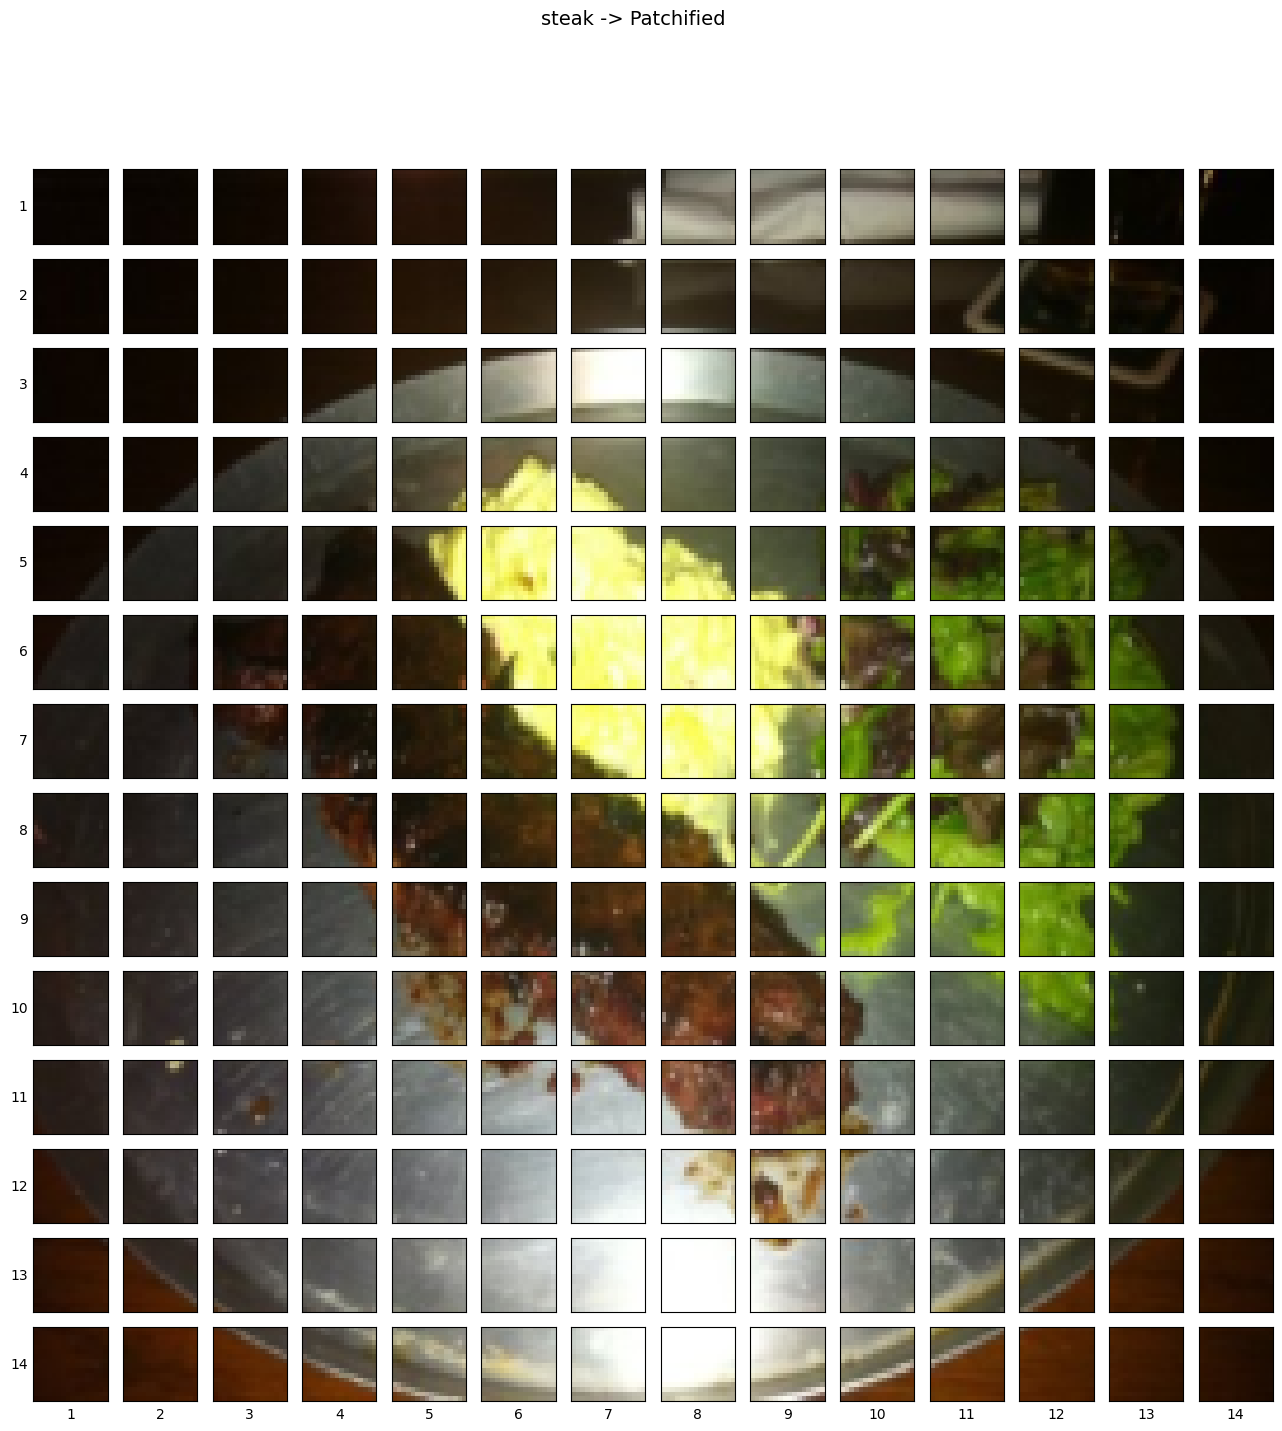

In [ ]:
# Setup code to plot whole image as patches
image_size = 224
patch_size = 16
# Use floor division (//) to ensure num_patches is an integer
num_patches = image_size // patch_size
assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches * num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
# Use num_patches for both nrows and ncols, ensuring they are integers
fig, axs = plt.subplots(nrows=num_patches, ncols=num_patches, sharex=True, sharey=True, figsize=(patch_size, patch_size))

# Loop throught the height and width of image
for i, patch_height in enumerate(range(0, image_size, patch_size)): # Iterate through height
  for j, patch_width in enumerate(range(0, image_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, patch_width:patch_width + patch_size, :]) # Iterate through height and width, and get all colour channels
    # Setup label information for each subplot (patch)
    axs[i, j].set_ylabel(i + 1, rotation = 'horizontal', horizontalalignment = 'right', verticalalignment = 'center')
    axs[i, j].set_xlabel(j + 1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize = 14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps, we could create the image patches and image patch emebddings in a single step using `torch.nn.Conv2d`, and setting the kernel size and stride parameters to `patch_size`.

In [ ]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels = 3, out_channels = 768, kernel_size = patch_size, stride = patch_size, padding = 0) # 768 from D size from Table 1
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

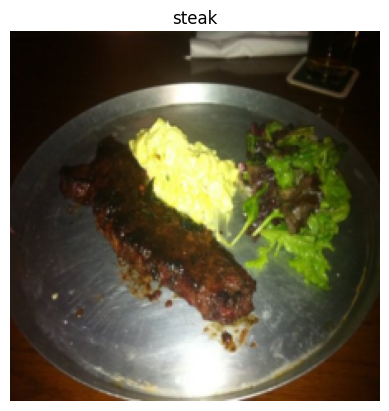

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim = 0)) # Add batch dimension (batch_size, colour_channels, height, width)
print({image_out_of_conv.shape})

{torch.Size([1, 768, 14, 14])}


Now, we've passed single image to our `conv2d` layer, its shape is:

torch.Size([1, 768, 14, 14]) -> # [batch_size, embedding_dim, feature_map_height, feature_map_width]

In [ ]:
image_out_of_conv

tensor([[[[-1.5784e-02, -1.6348e-02, -7.6418e-03,  ...,  2.8399e-02,
           -2.7116e-02, -5.0979e-02],
          [-1.8364e-02, -1.7133e-02, -1.1564e-02,  ...,  1.6045e-02,
            1.0609e-02, -3.0666e-02],
          [-1.8434e-02, -1.3078e-02, -2.0488e-03,  ...,  6.0475e-02,
            1.2254e-02, -1.9980e-02],
          ...,
          [ 5.5753e-02,  1.4948e-01,  2.5918e-01,  ...,  1.9789e-01,
            1.2028e-01,  5.8302e-03],
          [ 3.5021e-03,  5.6105e-02,  2.0184e-01,  ...,  2.7630e-01,
            4.9385e-02,  4.2254e-03],
          [ 4.1040e-03,  3.6507e-02,  7.0652e-02,  ...,  3.1659e-02,
            1.3558e-02, -1.1015e-03]],

         [[ 3.1235e-02,  3.2740e-02,  3.6888e-02,  ..., -2.1092e-02,
            2.4320e-02, -4.1590e-02],
          [ 3.1148e-02,  3.9031e-02,  3.9184e-02,  ..., -3.6639e-02,
            2.4279e-02,  3.4408e-02],
          [ 3.3219e-02,  3.7612e-02,  3.3528e-02,  ..., -4.7583e-02,
            3.7016e-02,  2.9677e-02],
          ...,
     

Showing random convolutional feature maps from indexes: [412, 351, 88, 22, 743]


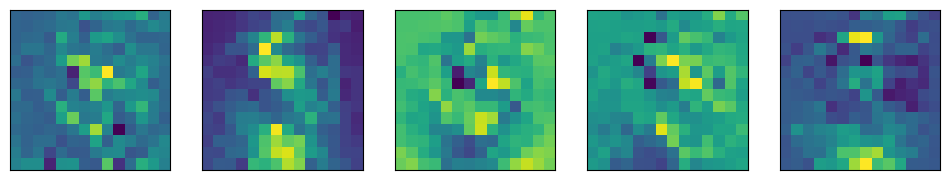

In [ ]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor of conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0158, -0.0163, -0.0076,  0.0155,  0.0358,  0.0301,  0.1470,
            0.4785,  0.4820,  0.3622,  0.2193,  0.0284, -0.0271, -0.0510],
          [-0.0184, -0.0171, -0.0116,  0.0070,  0.0300,  0.0626,  0.1349,
            0.1791,  0.1104,  0.0728,  0.0433,  0.0160,  0.0106, -0.0307],
          [-0.0184, -0.0131, -0.0020,  0.1646,  0.1613,  0.4364,  0.6350,
            0.5810,  0.2874,  0.1359,  0.1003,  0.0605,  0.0123, -0.0200],
          [-0.0146,  0.0346,  0.0691,  0.1724,  0.3000,  0.5370,  0.4889,
            0.3169,  0.2140,  0.1916,  0.1281,  0.0874,  0.0016, -0.0183],
          [ 0.0161,  0.0860,  0.1077,  0.0479,  0.3116,  0.7639,  0.7899,
            0.4880,  0.3440,  0.1392,  0.1947,  0.1849,  0.0669,  0.0051],
          [ 0.0477,  0.0601,  0.0785,  0.0188,  0.1029,  0.5163,  0.7675,
            0.8150,  0.3640,  0.1825,  0.1847,  0.2063,  0.0724,  0.0367],
          [ 0.0593,  0.0758,  0.1330,  0.0736,  0.0459,  0.4228,  0.6314,
            0.7997,  0.5400,  0.

### 4.4 Falattening the the patch embedding with `torch.nn.Flatten()`

Right now, we've got a series of convolutional feature maps that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [ ]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding dim, feature_map_height, feature_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch.nn import Flatten
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


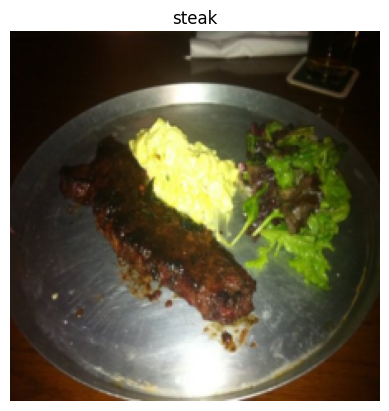

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim = 0)) # Add batch dimension
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [ ]:
# Rearrange output of flattened layer
print(f'{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> (batch_size, number_of_patches, embedding_dimension)')

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


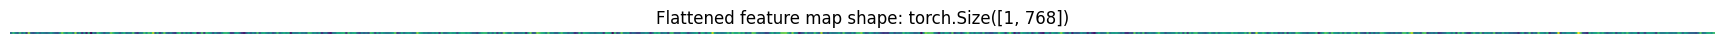

In [ ]:
# Get a single feature map
single_flattened_feature_map = image_out_of_conv_flattened[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);

### 4.5 Turning the ViT patch emebedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initiliase with appropriate hyperparameters, such as channels, embedding dimension, and patch size.
3. Create a layer to turn an image into embedded patches, using `nn.Conv2d`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` method that defines the foward computation (e.g. pass through layer from 3 to 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch emebedding.

In [ ]:
# 1. Create a class called PatchEmbedding
class PatchEmebedding(nn.Module):
  # 2. Initialise the layer with appropriate hyperparameters
  def __init__(self, in_channels: int = 3, embedding_dim: int = 768, patch_size: int = 16):
    super().__init__()
    # 3. Create a layer to turn an image into embedded layers
    self.patcher = nn.Conv2d(in_channels = in_channels, out_channels = embedding_dim, kernel_size = patch_size, stride = patch_size, padding = 0)
    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  # 5. Define the forward method for forward computation
  def forward(self, x: torch.Tensor):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an instance of PatchEmbedding layer
patchify = PatchEmebedding(in_channels = 3, embedding_dim = 768, patch_size = 16)

# Pass a single image through PatchEmbedding layer
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # Add an extra batch dimension
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.0441, -0.0100, -0.0330,  ...,  0.0252, -0.0214,  0.0179],
         [-0.0516, -0.0089, -0.0316,  ...,  0.0298, -0.0229,  0.0161],
         [-0.0705, -0.0101, -0.0320,  ...,  0.0381, -0.0313,  0.0168],
         ...,
         [-0.2023, -0.0195, -0.0372,  ...,  0.0879, -0.1264,  0.1123],
         [-0.1445, -0.0138, -0.0331,  ...,  0.0636, -0.0758,  0.0808],
         [-0.0916, -0.0129, -0.0378,  ...,  0.0384, -0.0445,  0.0609]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class tokn embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddeings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, number of patches + class token, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0441, -0.0100, -0.0330,  ...,  0.0252, -0.0214,  0.0179],
         [-0.0516, -0.0089, -0.0316,  ...,  0.0298, -0.0229,  0.0161],
         ...,
         [-0.2023, -0.0195, -0.0372,  ...,  0.0879, -0.1264,  0.1123],
         [-0.1445, -0.0138, -0.0331,  ...,  0.0636, -0.0758,  0.0808],
         [-0.0916, -0.0129, -0.0378,  ...,  0.0384, -0.0445,  0.0609]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddeings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, number of patches + class token, embedding_dim)


### 4.7 Creating a position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [ ]:
# View the patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0441, -0.0100, -0.0330,  ...,  0.0252, -0.0214,  0.0179],
          [-0.0516, -0.0089, -0.0316,  ...,  0.0298, -0.0229,  0.0161],
          ...,
          [-0.2023, -0.0195, -0.0372,  ...,  0.0879, -0.1264,  0.1123],
          [-0.1445, -0.0138, -0.0331,  ...,  0.0636, -0.0758,  0.0808],
          [-0.0916, -0.0129, -0.0378,  ...,  0.0384, -0.0445,  0.0609]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int(height * width / patch_size ** 2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches + 1, embedding_dimension))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])


### 4.8 Putting it altogether: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now, let's see it all in one cell.

In [ ]:
# Set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of original image, and get the image dimensions
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(dim = 0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmebedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)

# 5. Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True) # Make sure it's learnable
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f'Patch embedding with class token shape: {patch_embedding_with_class_token.shape}')

# 8. Create position embedding
number_of_patches = int(height * width / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches + 1, embedding_dimension), requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want out neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch, we can use `torch.nn.MultiheadAttention()`
* LayerNorm = Layer normalisation (LayrNorm) is a technique to normalise the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalisation accuracy.
  * Normalisation = make everything have the same mean and standard deviation.
  * In PyTorch = `torch.nn.LayerNorm()`, normalises values over $D$ dimension; in our case, the $D$ dimension is the embedding dimension.
  * When we normalise along the embedding dimension, it's like making all of the stairs int the staircase the same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dimension: int = 768, number_of_heads: int = 12, dropout_rate: float = 0.0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)

    # Create multihead attention layer (MSA) layer
    self.multihead_attention = nn.MultiheadAttention(embed_dim = embedding_dimension, num_heads = number_of_heads, dropout = dropout_rate, batch_first = True) # Is the batch first (batch, sequence, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x: torch.Tensor):
    x = self.layer_norm(x)
    attention_output, _ = self.multihead_attention(query = x, key = x, value = x, need_weights = False)
    return attention_output

In [ ]:
# Create an instance MSABlock
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dimension = 768, number_of_heads = 12, dropout_rate = 0.0)
multihead_self_attention_block

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Outpush shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Outpush shape of MSA block: torch.Size([1, 197, 768])


### 6. Equation 3L Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = quite a broad term for a block with a series of layers. Layers can be multiple or only one hidden layer.
  * Layers can mean fully-connected, dense, linear, fee-forward; all are often similar names for the same thing. In PyTorch, they're often `torch.nn.Linear()` and in TensorFlow, they might be called `tf.keras.layers.Dense()`.
  * GELU in PyTorch = `torch.nn.GELU()`.
  * MLP number of hidden units = MLP size in Table 1.
* **Dropout** = When used, it is applied after every dense layer except for the qkv-projections and direclty after adding positional embeddings to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3.

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dimension: int = 768, mlp_size: int = 3072, dropout_rate: int = 0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)

    # Create the MLP
    self.mlp = nn.Sequential(nn.Linear(in_features = embedding_dimension, out_features = mlp_size), nn.GELU(), nn.Dropout(p = dropout_rate), nn.Linear(in_features = mlp_size, out_features = embedding_dimension), nn.Dropout(p = dropout_rate))

  def forward(self, x: torch.Tensor):
    return self.mlp(self.layer_norm(x))

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dimension = 768, mlp_size = 12, dropout_rate = 0.1)

# Pass the output of MSA block through MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


### 7. Creating the Tranformer Encoder

The transformer encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.
* Encoder = turn a sequence into a learnable representation.
* Decoder = going from learned representations back to some sort of sequence.
* Residual connection = add a layer's input to its subsequent output; this enables the creation of deeper networks, and it prevents weights from getting small.

### 7.1 Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dimension: int = 768, num_heads: int = 12, mlp_size: int = 3072, mlp_dropout: int = 0.1, attention_dropout: int = 0): # All values form Table 1, mlp_dropout from Table 3
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dimension = embedding_dimension, number_of_heads = num_heads, dropout_rate = attention_dropout)

    # Creat MLP block
    self.mlp_block = MLPBlock(embedding_dimension = embedding_dimension, mlp_size = mlp_size, dropout_rate = mlp_dropout)

  def forward(self, x: torch.Tensor):
    x = self.msa_block(x) + x # Residual/skip connection for equation 2
    x = self.mlp_block(x) + x # Residual/skip connection for equation 2
    return x

In [ ]:
# Create an instance of TranformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
from torchinfo import summary
summary(model = transformer_encoder_block, input_size = (1, 197, 768), col_names = ['input_size', 'output_size', 'num_params', 'trainable'], col_width = 20, row_settings = ['var_names']) # input_size = (batch_size, number_of_patches, embedding_dimension)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far, we've created a transformer encoder by hand.

But because of how good the transformer architecture is, PyTorch has implemented ready-to-use Transformer Encoder layers.

We can create a Transformer Encoder with pure PyTorch layers.

In [ ]:
# Create the same as above with torch.nn.TransformerEncoder layer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768, nhead = 12, dim_feedforward = 3072, dropout = 0.1, activation = 'gelu', batch_first = True, norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer, input_size = (1, 197, 768), col_names = ['input_size', 'output_size', 'num_params', 'trainable'], col_width = 20, row_settings = ['var_names']) # input_size = (batch_size, number_of_patches, embedding_dimension)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### 8. Putting it all together to create ViT

In [ ]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self, image_size: int = 224, in_channels: int = 3, patch_size: int = 16, num_transformer_layers: int = 12, embedding_dimension: int = 768, mlp_size: int = 3072, num_heads: int = 12, attention_dropout: int = 0, mlp_dropout: int = 0.1, embedding_dropout: int = 0.1, num_classes: int = 1000):
      super().__init__()

      # Make an assertion that the image size is compatible with patch size
      assert image_size % patch_size == 0, f'Image size must be divisible by the patch size, image size: {image_size}, patch size: {patch_size}'

      # Calculate the number of patches (height * width / patch^2)
      self.num_patches = (image_size * image_size) // patch_size ** 2

      # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
      self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dimension), requires_grad = True)

      # Create learnable position embedding -  Initialize with zeros and let it learn
      self.position_embedding = nn.Parameter(data = torch.zeros(1, self.num_patches + 1, embedding_dimension), requires_grad = True)

      # Create embedding dropout value
      self.embedding_dropout = nn.Dropout(p = embedding_dropout)

      # Create patch embedding layer
      self.patch_embedding = PatchEmebedding(in_channels = in_channels, embedding_dim = embedding_dimension, patch_size = patch_size)

      # Create the Transformer Encoder block
      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dimension = embedding_dimension, num_heads = num_heads, mlp_size = mlp_size, mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

      # Create classifier head
      self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dimension), nn.Linear(in_features = embedding_dimension, out_features = num_classes))

  def forward(self, x: torch.Tensor):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (Equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (Equation 1)
    x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches, embedding_dim)

    # Add the position embedding to class token and patch embedding
    # Expand position embedding to match batch size
    position_embedding = self.position_embedding.expand(batch_size, -1, -1)
    x = position_embedding + x

    # Add dropout ot patch embedding ('directly after adding positional - to patch embeddings')
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Block (Equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put the 0th index logit through the classifier (Equtation 4)
    x = self.classifier(x[:, 0])

    return x

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working it (pizza, steak, suhsi)
vit = ViT(num_classes = 1000)

# Pass the random image tensor to out ViT instance
vit(random_image_tensor)

tensor([[ 5.2703e-01,  5.5212e-01, -3.6185e-01,  6.6555e-02,  3.1465e-01,
         -2.8244e-01,  4.1714e-01, -6.6181e-01, -1.5958e-01,  1.5336e-01,
          5.2154e-01, -9.6510e-02, -2.0741e-01,  6.1148e-01,  6.2691e-01,
          1.4107e+00, -9.0103e-01, -7.9612e-01,  3.7437e-01, -2.4403e-01,
         -5.1559e-01,  8.7872e-02,  3.0914e-01,  3.8633e-01,  2.2656e-01,
         -7.0040e-01, -2.7808e-01,  6.2814e-01,  3.5177e-02,  4.3147e-01,
          3.8178e-01, -6.7814e-01, -2.1301e-01,  9.4174e-01, -7.8705e-01,
          3.6076e-01, -2.0654e-02, -2.8898e-01, -6.2096e-02,  6.5320e-01,
          6.6193e-01, -3.8204e-01, -1.0631e+00, -6.7939e-01, -5.4917e-01,
          5.4127e-01, -3.6240e-01, -5.4157e-01, -7.1109e-01, -9.8042e-02,
         -7.8262e-01, -3.0632e-01,  6.1555e-01,  5.9400e-01, -2.7229e-02,
          7.2170e-01,  4.1088e-01,  3.0468e-01, -1.0804e+00,  1.0321e+00,
          3.1285e-01,  1.4953e-01, -8.5401e-01, -5.7763e-01,  5.9495e-01,
          5.3953e-01, -1.3222e+00,  6.

### 8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary
summary(model = ViT(num_classes = len(class_names)), input_size = (1, 3, 224, 224), col_names = ['input_size', 'output_size', 'num_params', 'trainable'], col_width = 20, row_settings = ['var_names']) # input_size = (batch_size, colour_channels, height,  width)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmebedding (patch_embedding)                               [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                           [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           

### 9. Setting up training code for our custom ViT

We've replicated the ViT architecture; now, let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an optimiser

The paper states it uses the Adam optimiser (section 4, Training and fine-tuning) with $B1$ value of 0.9, and $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = A regularisation technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model) to the loss function.

Regularisation technique = prevents overfitting.

### 9.2 Creating a loss function

The ViT doesn't mention the loss function they used.

So, since it's a multiclass classification problem, we'll use the `torch.nn.CrossEntropyLoss()`

In [ ]:
optimiser = torch.optim.Adam(params = vit.parameters(), lr = 1e-3, betas = (0.9, 0.999), weight_decay = 0.1)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our ViT model

In [ ]:
device

'cuda'

In [ ]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model = vit, train_dataloader = train_dataloader, test_dataloader = test_dataloader, optimizer = optimiser, loss_fn = loss_fn, epochs = 10, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3920 | train_acc: 0.3242 | test_loss: 1.8692 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6220 | train_acc: 0.2500 | test_loss: 1.7265 | test_acc: 0.2292
Epoch: 3 | train_loss: 1.8006 | train_acc: 0.2891 | test_loss: 1.0732 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2790 | train_acc: 0.4297 | test_loss: 2.2724 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.5096 | train_acc: 0.3125 | test_loss: 1.3475 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.3597 | train_acc: 0.2891 | test_loss: 1.9808 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.4473 | train_acc: 0.4297 | test_loss: 2.9905 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.6756 | train_acc: 0.2852 | test_loss: 1.4331 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3139 | train_acc: 0.4102 | test_loss: 1.2419 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.5295 | train_acc: 0.2734 | test_loss: 1.1429 | test_acc: 0.2604


### 9.4 What our training setup is missing?

How is our training setup different to the ViT paper?

We've replicated the model architecture correctly.

But what was different between our training procedure (to get such poor results), and the ViT paper training procedure to get such great results.

The main things our trainign implementation is missing:


Prevent underfitting
* Data - Our setup uses far less data (225 vs millions)

Prevent overfitting
* Learning rate warmup - Starts with a low learning rate, and icrease to a base learning rate.
* Learning rate decay - As your model gets closer to convergence, start to lower the learning rate.
* Gradient clipping - Prevents gradients from getting too big.

Search 'PyTorch [technique name]'

### 9.5 Plotting loss curves for our model

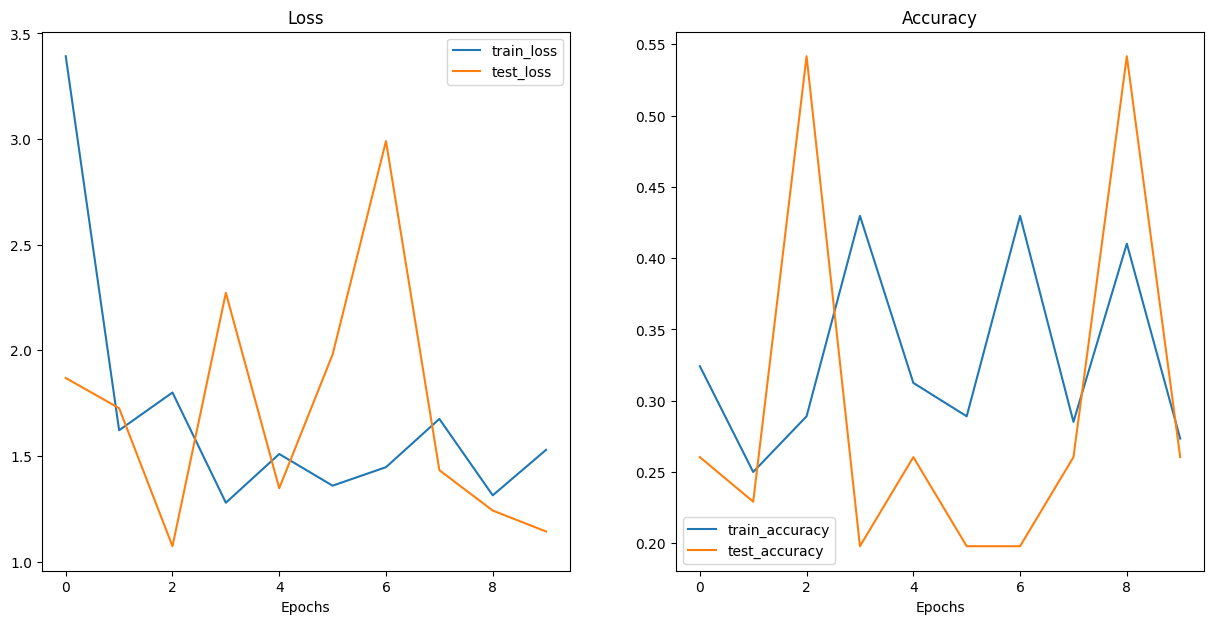

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning, if you can use a pretrained model from a large dataset on your problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning, give it a go. It often achieves great results with little data.

### 10.1 **Why use a pretrained model?**

* Sometimes, data is limited.
* Limited training resources.
* Get better results results faster (sometimes).

In [ ]:
# Thw following requires torch 0.12+ torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 'DEFAULT' = Best available

# Setup a ViT model instance with pretrained weights
pretrained_vit_model = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for paramter in pretrained_vit_model.parameters():
  paramter.requires_grad = False

# Update the classifier head
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit_model.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


In [ ]:
from torchinfo import summary
summary(model = pretrained_vit_model, input_size = (1, 3, 224, 224), col_names = ['input_size', 'output_size', 'num_params', 'trainable'], col_width = 20, row_settings = ['var_names']) # input_size = (batch_size, colour_channels, height,  width)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way the model wa pretrained on.

In [ ]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup some dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir, test_dir = test_dir, transform = vit_transforms, batch_size = 32) # Could set a higher batch size here because using a pretrained model

### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimiser and loss function
optimiser = torch.optim.Adam(params = pretrained_vit_model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(model = pretrained_vit_model, train_dataloader = train_dataloader_pretrained, test_dataloader = test_dataloader_pretrained, optimizer = optimiser, loss_fn = loss_fn, epochs = 10, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

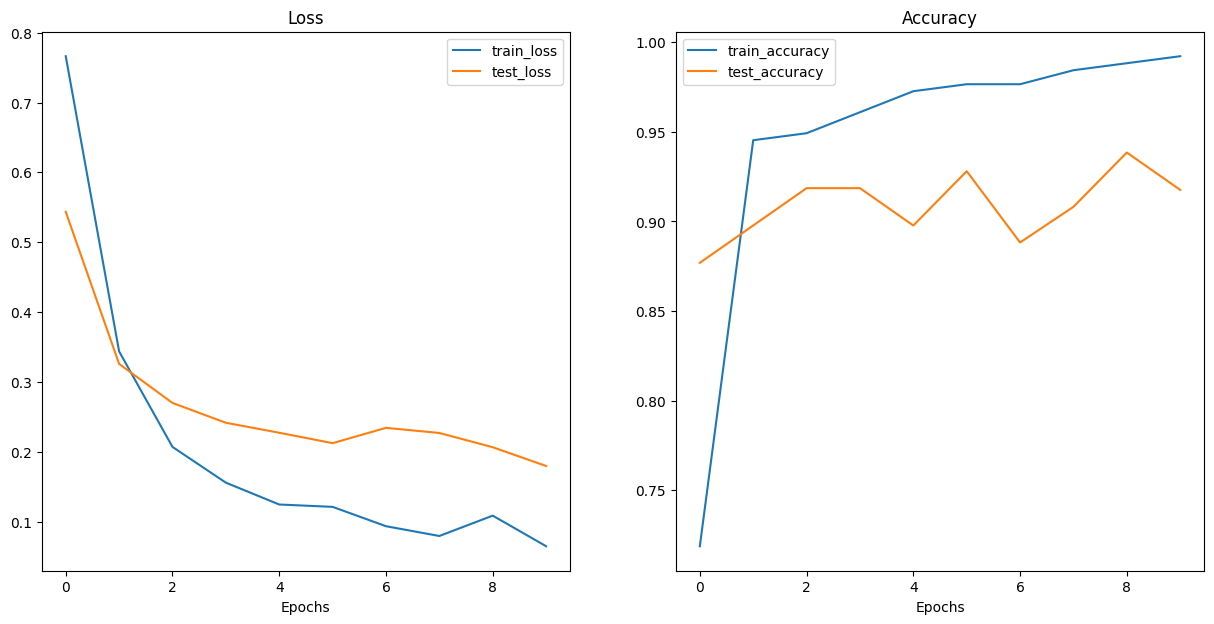

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model


Now, we've got a model that performs quite well, how about we save it to file and then check its file size.

We want to check its file size because if we wanted to deploy a model, say a website/mobile application, we may have limtiations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit_model, target_dir = 'models', model_name = '08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes, then convert to megabytes
pretrained_model_vit_size = Path('models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024 * 1024)
print(f'Pretrained ViT model size: {pretrained_model_vit_size} MB')

Pretrained ViT model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini proeblem; however, the model size is ~ 11x larger than our next best performing model.

Perhaps, the larger model size might cause issues when go to deploy it (e.g hard to deploy such a large file.might not make predictions as fast as a smaller model).

### 11. Predicting on a custom image

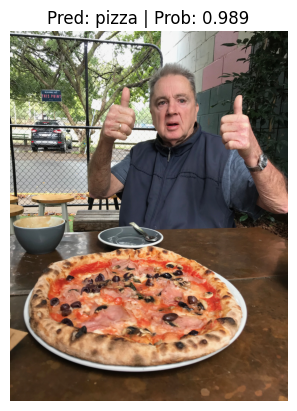

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model = pretrained_vit_model, image_path = custom_image_path, class_names = class_names)